In [1]:
suppressWarnings({
    library(lmerTest)
    library(lme4)
    library(ggplot2)
    library(dplyr)
    library(tidyr)
    library(sjPlot)
    library(IRdisplay)
    library(car)
    library(ggeffects)
    library(gridExtra)
})


Loading required package: lme4
Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack

Learn more about sjPlot with 'browseVignettes("sjPlot")'.
Loading required package: carData
Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode


Attaching package: ‘gridExtra’

The follow

# Investigating MHWs + Phytoplankton Performance Response via LMMs

Tony Cannistra, May 2020

**Purpose**: To experiment with linear mixed effects models to examine whether a significant relationship exists between latitude, sea surface temperature, and performance ratio during marine heatwave events. 

**Method**: Build a linear mixed model of performance ratio with the following effects: 

*Fixed*: 
* latitude + Latitude ^2
* mean_sst_event_year_local

*Random*:
* phytoplankton isolate
* season?

Perhaps season should be a fixed effect, especially since it likely does have control over the direction + shape of the curve. 

## Data

We compute individual isolate performance for all local heatwaves in [this notebook](../Individual_Isolate_performance.ipynb), and use these data below. 

In [2]:
mhwPerformance <- read.csv("../isolate_performance.csv")
mhwPerformance = mhwPerformance %>% mutate(isolate = factor(isolate))
head(mhwPerformance)

X,lat,lon,isolate,mhw,detriment_sum,relative_detriment_mean,detriment_mean,performance_diff_mean,performance_ratio_mean,...,intensity_mean,duration,start_doy,peak_doy,current_year_sst_mean,start_date,peak_date,perf_det_ratio,latbin,doy_bins
0,-74.875,164.625,1,4,3.433027,1.303966,0.4291283,0.039389031,0.5619743,...,1.2978105,9,1,1,-1.202301,1986-12-31,5.364576e+17,0.8461350,"(-75.026, -59.75]","(0.639, 91.25]"
1,-74.875,164.625,1,5,6.265167,1.269172,0.4176778,0.047724486,0.4845732,...,1.5283193,16,21,32,-1.103370,1987-01-21,5.391360e+17,0.8156109,"(-75.026, -59.75]","(0.639, 91.25]"
2,-74.875,164.625,1,11,9.585366,1.713322,0.5638451,0.005772556,0.9523635,...,0.1877301,18,232,244,-1.168743,1988-08-19,5.889888e+17,0.9795979,"(-75.026, -59.75]","(181.5, 271.75]"
3,-74.875,164.625,1,14,10.139295,1.711648,0.5632942,0.005368716,0.9553548,...,0.1741022,19,196,201,-1.181397,1989-07-15,6.168960e+17,0.9809409,"(-75.026, -59.75]","(181.5, 271.75]"
4,-74.875,164.625,1,37,6.210158,1.715494,0.5645598,0.004782467,0.9600958,...,0.1560303,12,215,220,-1.219370,1995-08-03,8.078400e+17,0.9829606,"(-75.026, -59.75]","(181.5, 271.75]"
5,-74.875,164.625,1,69,5.665564,1.721560,0.5665564,0.004160394,0.9652134,...,0.1353238,11,133,138,-1.088333,2004-05-12,1.084752e+18,0.9851187,"(-75.026, -59.75]","(91.25, 181.5]"


We need to adjust for the effect of hemisphere to "align" seasons and convert to "season" factor variables from "peak_doy" column:

In [3]:
mhwPerformance[between(mhwPerformance$lat, -90, 0), 'peak_doy'] = (mhwPerformance[between(mhwPerformance$lat, -90, 0), 'peak_doy'] - 180) %% 365

In [4]:
mhwPerformance = mhwPerformance %>%  
                    mutate(season = 
                           case_when(
                                (between(peak_doy, 0, 77) | between(peak_doy, 355, 366)) ~ "winter", # January 1 - March XX or December XX - December 31
                                between(peak_doy, 78, 170) ~ "spring", # March XX - June XX
                                between(peak_doy, 171, 295) ~ "summer", # June XX - September XX
                                between(peak_doy, 296, 354) ~ "fall" # September XX - December XX
                        )
                    )

In [5]:
head(mhwPerformance %>% select(peak_doy, season))

peak_doy,season
186,summer
217,summer
64,winter
21,winter
40,winter
323,fall


We'll clean up by dropping NAs and `Inf`s 

In [6]:
mhwPerformance = mhwPerformance %>% filter(!is.na(performance_ratio_mean)) %>% filter(is.finite(performance_ratio_mean))

In [7]:
perfratio_quantile <- quantile(mhwPerformance$performance_ratio_mean, probs=c(.25, .75), na.rm = FALSE)
perfratio_iqr  <- IQR(mhwPerformance$performance_ratio_mean)
perfratio_low  <-  perfratio_quantile[2]+1.5*perfratio_iqr # Upper Range  
perfratio_high <- perfratio_quantile[1]-1.5*perfratio_iqr # Lower Range﻿

In [8]:
mhwPerformace = mhwPerformance %>% filter(performance_ratio_mean > perfratio_low & performance_ratio_mean < perfratio_high)

We'll also **scale the input variables** for later, but the initial models will use the raw values: 

In [9]:
mhwPerformance = mhwPerformance %>%
    mutate(
        lat_scaled = scale(lat),
        sst_scaled = scale(current_year_sst_mean), 
        abslat_scaled = scale(abs(lat))
    )

## Is `season` a random or fixed effect?

Warning message:
“Removed 279 rows containing non-finite values (stat_boxplot).”

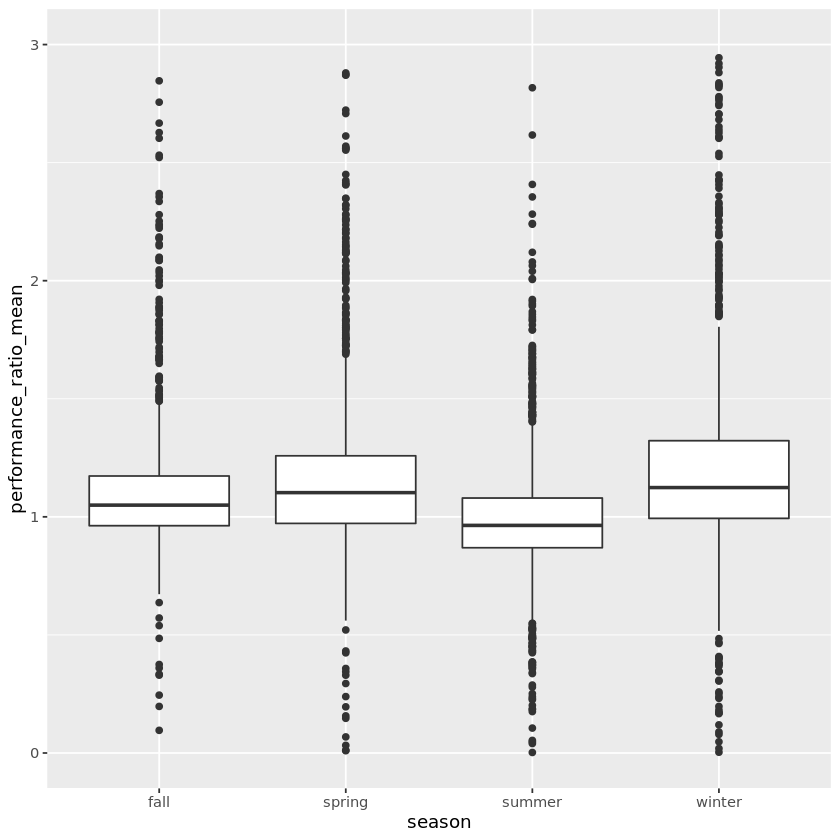

In [19]:
ggplot(mhwPerformance, aes(x = season, y = performance_ratio_mean)) + geom_boxplot() + ylim(0, 3)

## Models

We'll start with a simple linear model with all terms, **excluding** interaction terms:

In [13]:
simple_lm = lm(performance_ratio_mean ~ (poly(lat_scaled, 2) + sst_scaled + season)  , data=mhwPerformance)
summary(simple_lm)


Call:
lm(formula = performance_diff_mean ~ (poly(lat_scaled, 2) + sst_scaled + 
    season), data = mhwPerformance)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.69436 -0.02396  0.00072  0.02838  0.36446 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.014944   0.002298   6.503 8.60e-11 ***
poly(lat_scaled, 2)1  0.625775   0.075020   8.341  < 2e-16 ***
poly(lat_scaled, 2)2 -1.639401   0.170999  -9.587  < 2e-16 ***
sst_scaled           -0.036310   0.002406 -15.093  < 2e-16 ***
seasonspring          0.010624   0.002889   3.677 0.000239 ***
seasonsummer         -0.040609   0.002717 -14.945  < 2e-16 ***
seasonwinter          0.024243   0.002988   8.113 6.09e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0646 on 5292 degrees of freedom
Multiple R-squared:  0.1907,	Adjusted R-squared:  0.1898 
F-statistic: 207.8 on 6 and 5292 DF,  p-value: < 2.2e-16


In [14]:
baseline_hline = geom_hline(yintercept=1, linetype='dashed', color='blue', size=0.6, alpha=0.6)

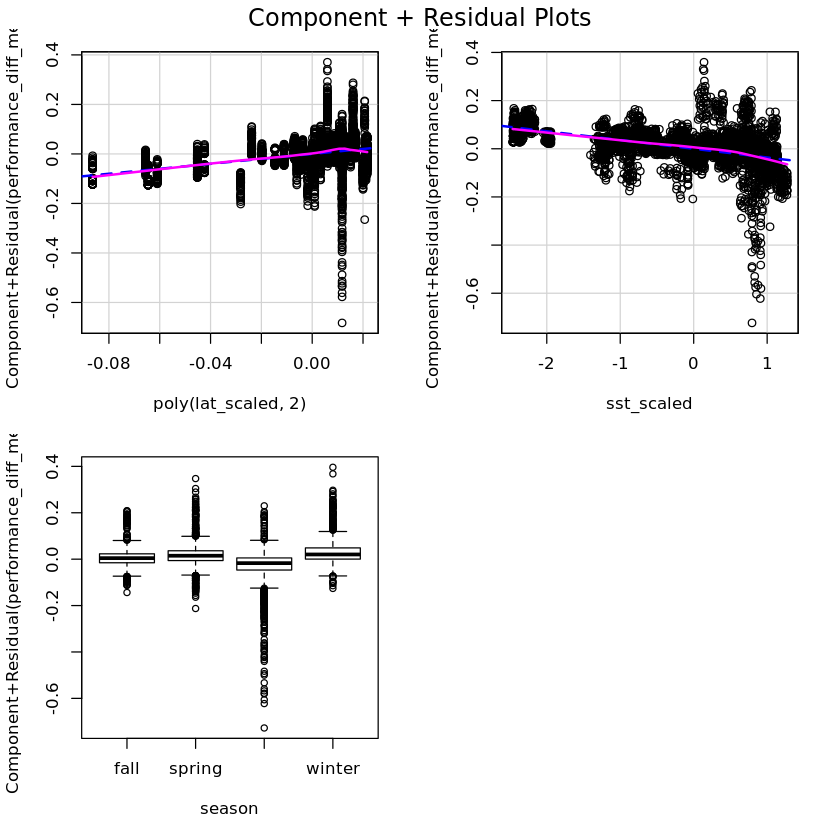

In [16]:
crPlots(simple_lm)


## Simple Model with Random Effects

Only `isolate` as random effect for now: 

In [17]:
simple_re = lmer(performance_ratio_mean ~ (poly(lat_scaled, 2) + sst_scaled + season)^2 + (1|isolate), data=mhwPerformance)
summary(simple_re)


Correlation matrix not shown by default, as p = 18 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ (poly(lat_scaled, 2) + sst_scaled +  
    season)^2 + (1 | isolate)
   Data: mhwPerformance

REML criterion at convergence: 42520.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-18.233  -0.038  -0.005   0.012  65.065 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept)   1.505   1.227  
 Residual             181.400  13.468  
Number of obs: 5299, groups:  isolate, 75

Fixed effects:
                                    Estimate Std. Error         df t value
(Intercept)                          0.98002    0.57029  467.17939   1.718
poly(lat_scaled, 2)1                -1.95266   49.89719  371.26766  -0.039
poly(lat_scaled, 2)2                 1.33119  108.08770  569.38484   0.012
sst_scaled                           0.08586    1.44739 1121.59628   0.059
seasonspring                         0.67935    0.60583 5262.48631   1.121
s

Model contains splines or polynomial terms. Consider using `terms="lat_scaled [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


Error: Confidence intervals could not be computed.
* Reason: "`season` does not have enough factor levels. Try to remove `[]`."
* Source: .safe_se_from_vcov(model, prediction_data, value_adjustment, terms, model_class, type, vcov.fun, vcov.type, vcov.args, condition, interval)


Model contains splines or polynomial terms. Consider using `terms="sst_scaled [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


Error: Confidence intervals could not be computed.
* Reason: "`season` does not have enough factor levels. Try to remove `[]`."
* Source: .safe_se_from_vcov(model, prediction_data, value_adjustment, terms, model_class, type, vcov.fun, vcov.type, vcov.args, condition, interval)


Model contains splines or polynomial terms. Consider using `terms="season [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


NULL

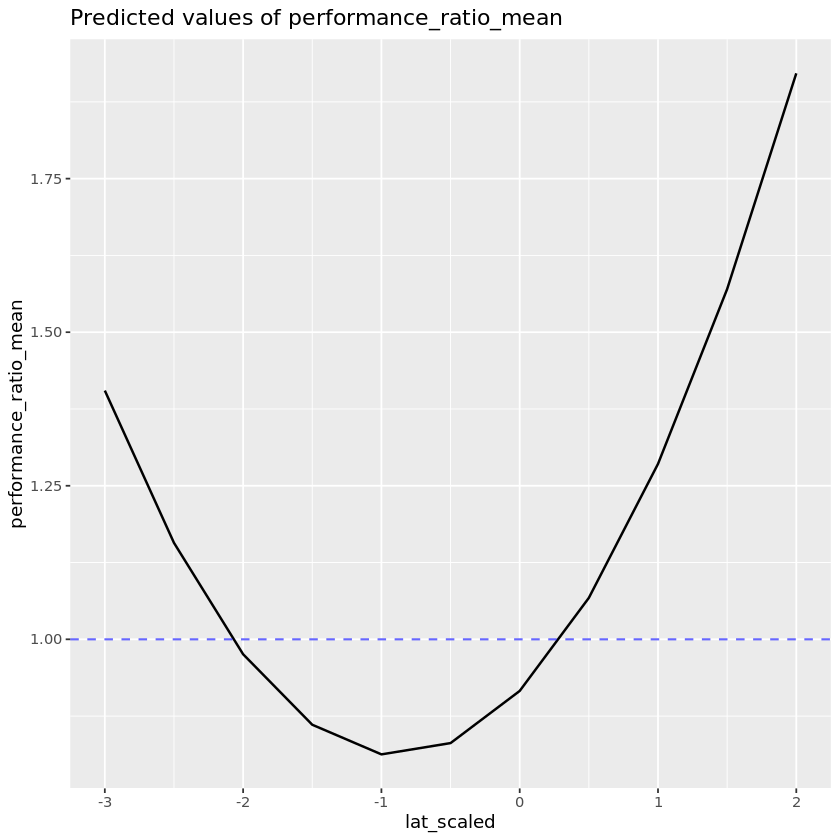

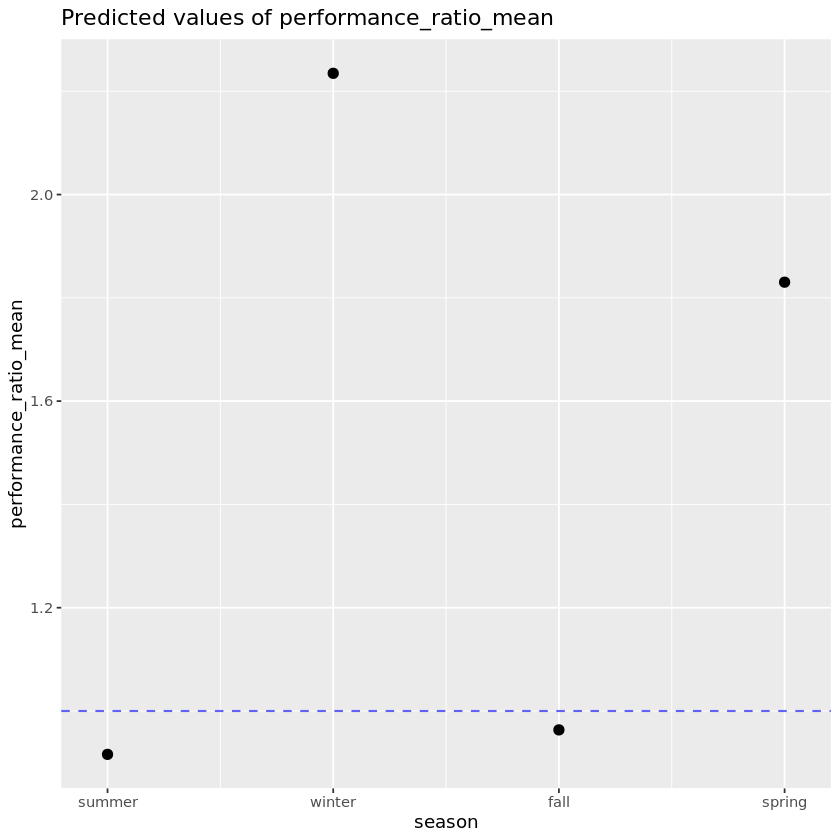

In [395]:
simple_re_plots = plot_model(simple_re, type='pred')
simple_re_plots$lat + baseline_hline
simple_re_plots$current_year_sst_mean + baseline_hline
simple_re_plots$season + baseline_hline

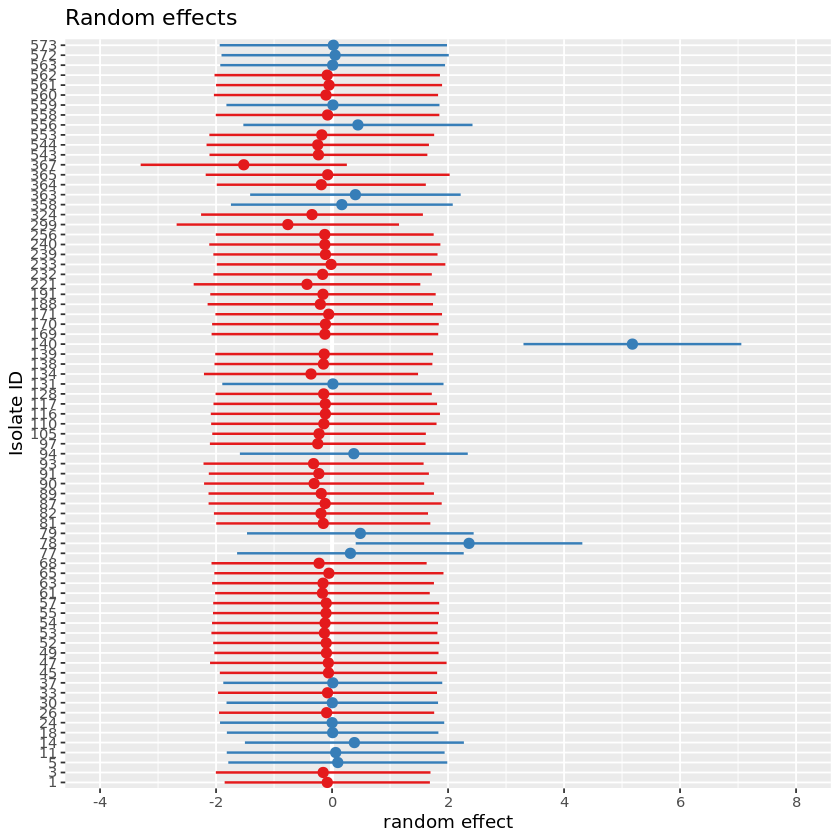

In [396]:
plot_model(simple_re, type='re') + xlab("Isolate ID") + ylab('random effect')

**Random Effects model with Season**

In [397]:
season_re = lmer(performance_ratio_mean ~ poly(lat,2) + current_year_sst_mean + poly(lat,2)*current_year_sst_mean + season-1  +  (1 | isolate), data=mhwPerformance)
summary(season_re)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ poly(lat, 2) + current_year_sst_mean +  
    poly(lat, 2) * current_year_sst_mean + season - 1 + (1 |      isolate)
   Data: mhwPerformance

REML criterion at convergence: 42596.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-18.242  -0.038  -0.009   0.012  65.124 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept)   1.512   1.23   
 Residual             181.159  13.46   
Number of obs: 5299, groups:  isolate, 75

Fixed effects:
                                      Estimate Std. Error         df t value
poly(lat, 2)1                        -1.311014  30.033400  65.820296  -0.044
poly(lat, 2)2                       -13.722640  45.543416  72.448954  -0.301
current_year_sst_mean                -0.007912   0.085676  81.840521  -0.092
seasonfall                            1.149565   1.619268 100.287444   0.710
seasonspring      

Model contains splines or polynomial terms. Consider using `terms="lat [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


Error: Confidence intervals could not be computed.
* Reason: "`season` does not have enough factor levels. Try to remove `[]`."
* Source: .safe_se_from_vcov(model, prediction_data, value_adjustment, terms, model_class, type, vcov.fun, vcov.type, vcov.args, condition, interval)


Model contains splines or polynomial terms. Consider using `terms="current_year_sst_mean [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


Error: Confidence intervals could not be computed.
* Reason: "`season` does not have enough factor levels. Try to remove `[]`."
* Source: .safe_se_from_vcov(model, prediction_data, value_adjustment, terms, model_class, type, vcov.fun, vcov.type, vcov.args, condition, interval)


Model contains splines or polynomial terms. Consider using `terms="season [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


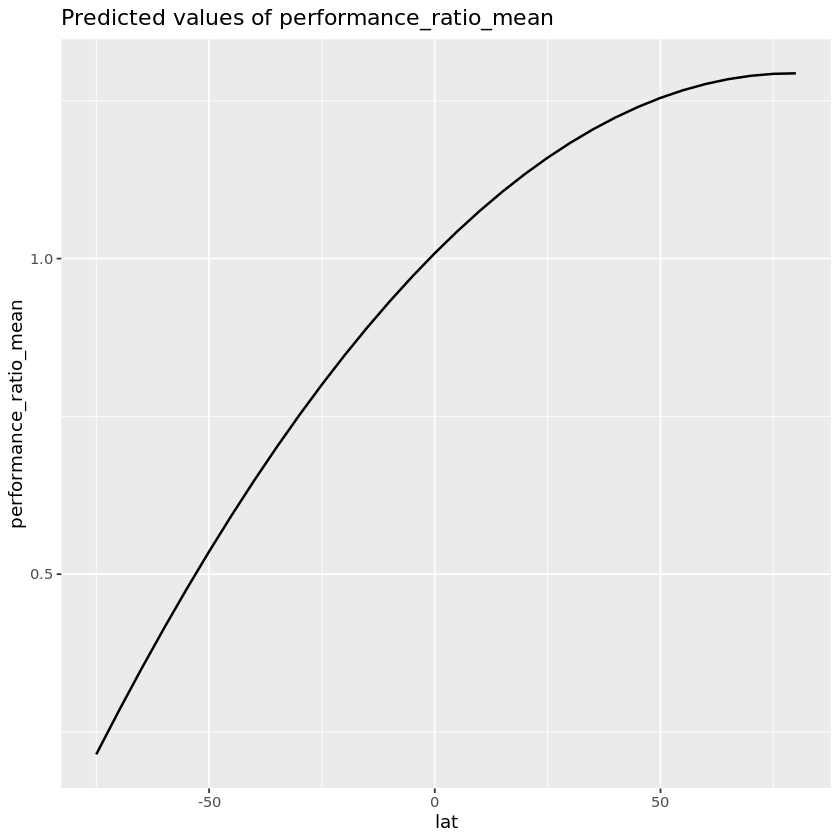

$lat

$current_year_sst_mean

$season


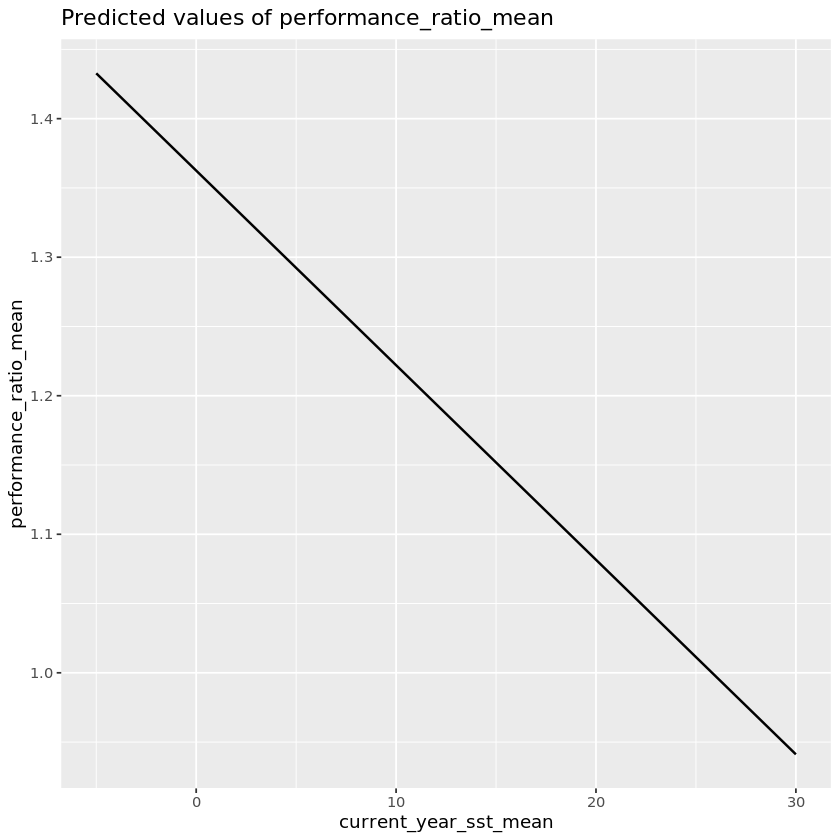

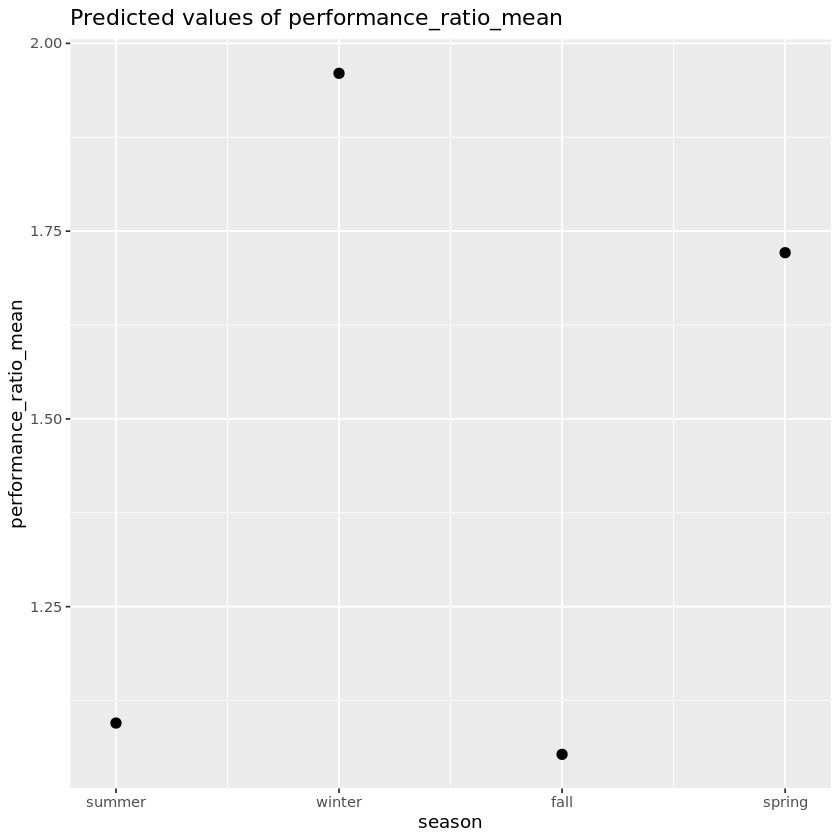

In [398]:
plot_model(season_re, type='pred')

## More Intense Heatwaves =? Stronger Signal?

There's probably a lot of noise from shorter events here. 

Lets take a look at the distribution of heatwaves by intensity: 

In [399]:
median(mhwPerformance$intensity_mean)

[1] 1.519607

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


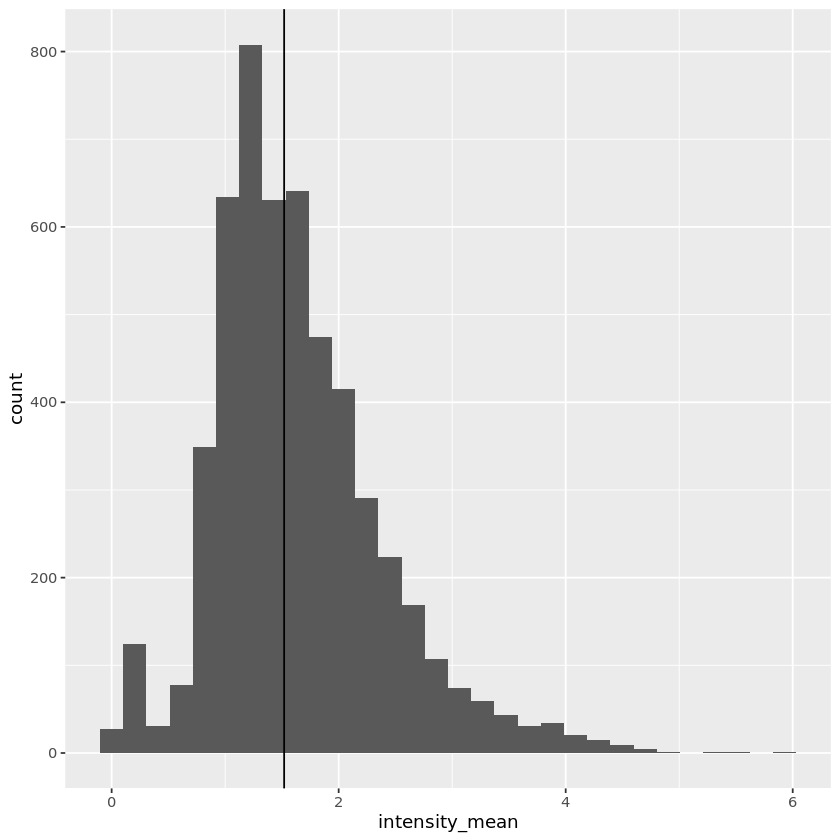

In [400]:
ggplot(mhwPerformance, aes(x=intensity_mean) ) + geom_histogram() + geom_vline(xintercept=median(mhwPerformance$intensity_mean)) 

We can use ~1.5 C as our threshold (median?)

In [401]:
intensity_threshold = 1.5

In [402]:
intenseMhwPerformance = mhwPerformance %>% filter(intensity_mean > intensity_threshold)

In [403]:
head(intenseMhwPerformance)

X,lat,lon,isolate,mhw,detriment_sum,relative_detriment_mean,detriment_mean,performance_diff_sum,performance_ratio_mean,...,current_year_sst_mean,start_date,peak_date,perf_det_ratio,latbin,doy_bins,season,lat_scaled,sst_scaled,abslat_scaled
1,-74.875,164.625,1,5,6.2651666,1.26917212,0.41767777,1.4179882,0.4845732,...,-1.10337,1987-01-21,5.391360e+17,8.156109e-01,"(-75.026, -59.75]","(0.639, 91.25]",summer,-2.537581,-2.432479754,2.40863645
19,-57.875,139.875,558,6,0.8048469,0.14412670,0.04734394,-0.7973536,0.8569843,...,2.37748,1985-01-03,4.737312e+17,3.234330e+04,"(-59.75, -44.625]","(0.639, 91.25]",summer,-2.047310,-2.012213646,1.43853309
27,-41.375,174.875,18,30,1.2221654,0.09605062,0.02909918,0.9946192,1.0947682,...,14.94652,1999-02-08,9.217152e+17,5.517525e-01,"(-44.625, -29.5]","(0.639, 91.25]",summer,-1.571460,-0.494669663,0.49696219
34,-36.125,174.875,573,53,1.7526555,0.07958929,0.04736907,3.0075834,1.1757085,...,17.80997,2017-11-28,1.512950e+18,3.521463e-01,"(-44.625, -29.5]","(0.639, 91.25]",spring,-1.420053,-0.148946286,0.19737144
37,-34.375,17.125,26,42,0.2014159,0.08242058,0.03356932,-0.1750949,0.9275738,...,18.40364,2005-07-15,1.121558e+18,7.700049e+00,"(-44.625, -29.5]","(181.5, 271.75]",winter,-1.369584,-0.077268109,0.09750786
38,-34.375,17.125,26,45,4.8919199,0.48043255,0.19567680,-2.2139308,0.7046092,...,19.01186,2007-03-01,1.174262e+18,1.827904e+00,"(-44.625, -29.5]","(0.639, 91.25]",summer,-1.369584,-0.003833995,0.09750786


In [404]:
nrow(intenseMhwPerformance)

[1] 2721

**Simple Model**

In [405]:
simple_intense_lm = lm(performance_ratio_mean ~ (abs(lat) +current_year_sst_mean +  season)^2, data=intenseMhwPerformance)
summary(simple_intense_lm)


Call:
lm(formula = performance_ratio_mean ~ (abs(lat) + current_year_sst_mean + 
    season)^2, data = intenseMhwPerformance)

Residuals:
    Min      1Q  Median      3Q     Max 
-247.90   -0.33   -0.06    0.17  880.72 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)
(Intercept)                         4.429721   9.772668   0.453    0.650
abs(lat)                           -0.093552   0.148210  -0.631    0.528
current_year_sst_mean              -0.103045   0.314720  -0.327    0.743
seasonspring                        0.393467  11.170362   0.035    0.972
seasonsummer                       -0.822959  10.604623  -0.078    0.938
seasonwinter                       -3.677075  12.240877  -0.300    0.764
abs(lat):current_year_sst_mean      0.002585   0.003414   0.757    0.449
abs(lat):seasonspring               0.018602   0.156247   0.119    0.905
abs(lat):seasonsummer               0.046976   0.149198   0.315    0.753
abs(lat):seasonwinter             

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


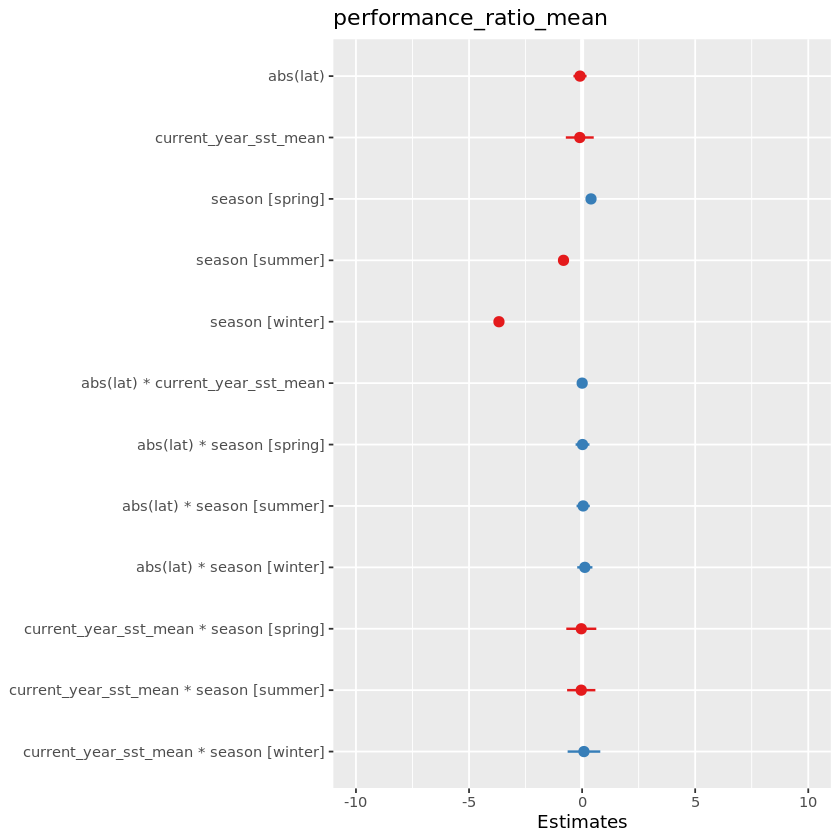

In [406]:
plot_model(simple_intense_lm)+ ylim(-10, 10)

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 0.985”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.015”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  2.1753e-16”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 4.0602”

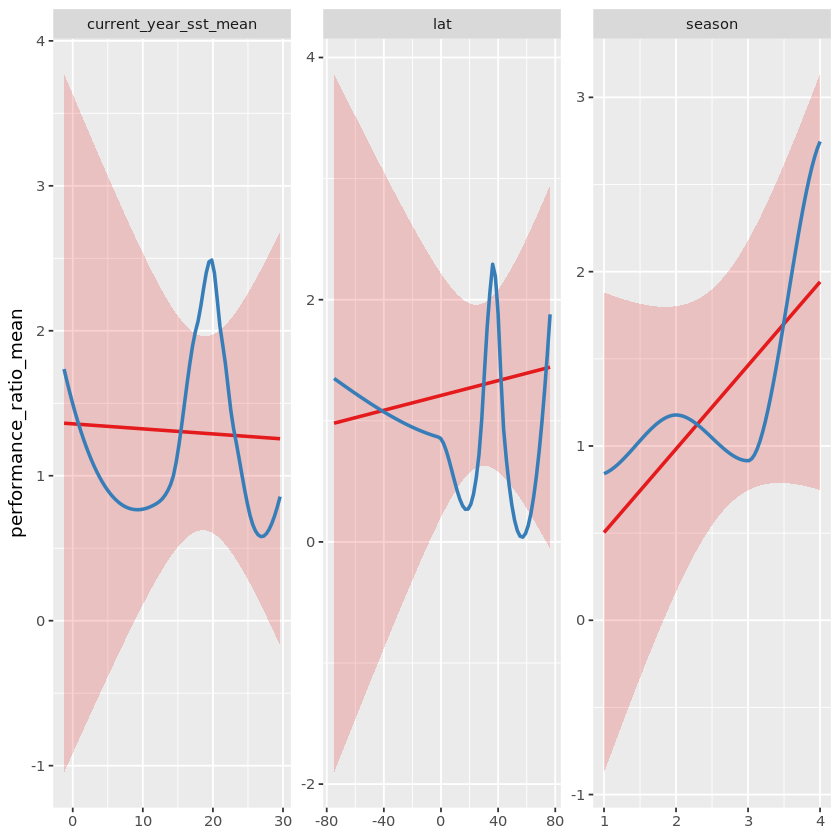

In [407]:
plot_model(simple_intense_lm, type='slope',)

**Simple Random Effects**

In [408]:
simple_intense_re = lmer(performance_ratio_mean ~ (poly(lat,2) + current_year_sst_mean  + season)^2 + (1 | isolate), data=intenseMhwPerformance, )

Warning message:
“Some predictor variables are on very different scales: consider rescaling”Warning message:
“Some predictor variables are on very different scales: consider rescaling”

In [409]:
summary(simple_intense_re)


Correlation matrix not shown by default, as p = 18 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ (poly(lat, 2) + current_year_sst_mean +  
    season)^2 + (1 | isolate)
   Data: intenseMhwPerformance

REML criterion at convergence: 23295.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-13.876  -0.018   0.000   0.016  49.303 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept)   2.079   1.442  
 Residual             315.732  17.769  
Number of obs: 2721, groups:  isolate, 69

Fixed effects:
                                      Estimate Std. Error         df t value
(Intercept)                          1.343e+00  5.872e+00  1.180e+03   0.229
poly(lat, 2)1                       -3.253e+01  7.344e+01  8.708e+02  -0.443
poly(lat, 2)2                       -4.537e+01  9.570e+01  1.627e+03  -0.474
current_year_sst_mean               -2.521e-02  3.100e-01  1.093e+03  -0.081
seasonspring                         1.127e+00  6.905e+

In [415]:
simple_intense_scaled_re = lmer(performance_ratio_mean ~ (poly(lat_scaled,2) + sst_scaled  + season)^2 + (1 | isolate), data=intenseMhwPerformance, )

In [416]:
summary(simple_intense_scaled_re)


Correlation matrix not shown by default, as p = 18 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ (poly(lat_scaled, 2) + sst_scaled +  
    season)^2 + (1 | isolate)
   Data: intenseMhwPerformance

REML criterion at convergence: 23270.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-13.876  -0.018   0.000   0.016  49.303 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept)   2.079   1.442  
 Residual             315.732  17.769  
Number of obs: 2721, groups:  isolate, 69

Fixed effects:
                                    Estimate Std. Error         df t value
(Intercept)                          0.86289    1.01275  771.41808   0.852
poly(lat_scaled, 2)1               -15.26167   58.00319  973.13991  -0.263
poly(lat_scaled, 2)2               -27.21683   97.53046  891.65250  -0.279
sst_scaled                          -0.20882    2.56794 1092.54040  -0.081
seasonspring                         0.43015    1.16818 2689.08018   

In [412]:
anova(simple_intense_re, simple_intense_scaled_re)

refitting model(s) with ML (instead of REML)


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
simple_intense_re,20,23417.94,23536.11,-11688.97,23377.94,NA,NA,NA
simple_intense_scaled_re,20,23417.94,23536.11,-11688.97,23377.94,3.637979e-12,0,0


Model contains splines or polynomial terms. Consider using `terms="season [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


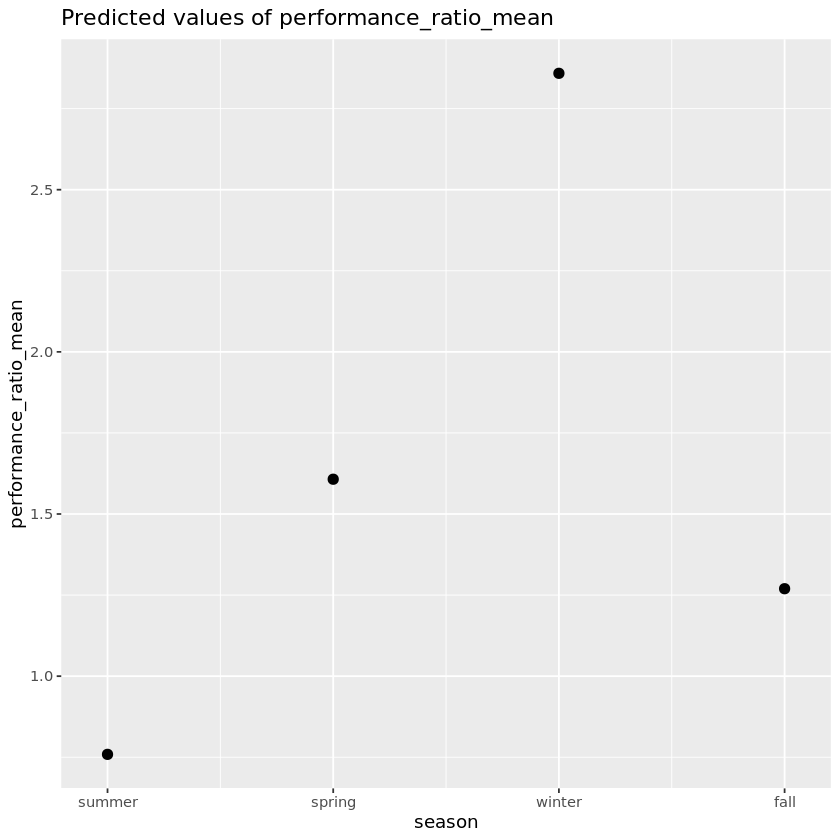

In [413]:
plot_model(simple_intense_re, type='pred', terms=c("season"))

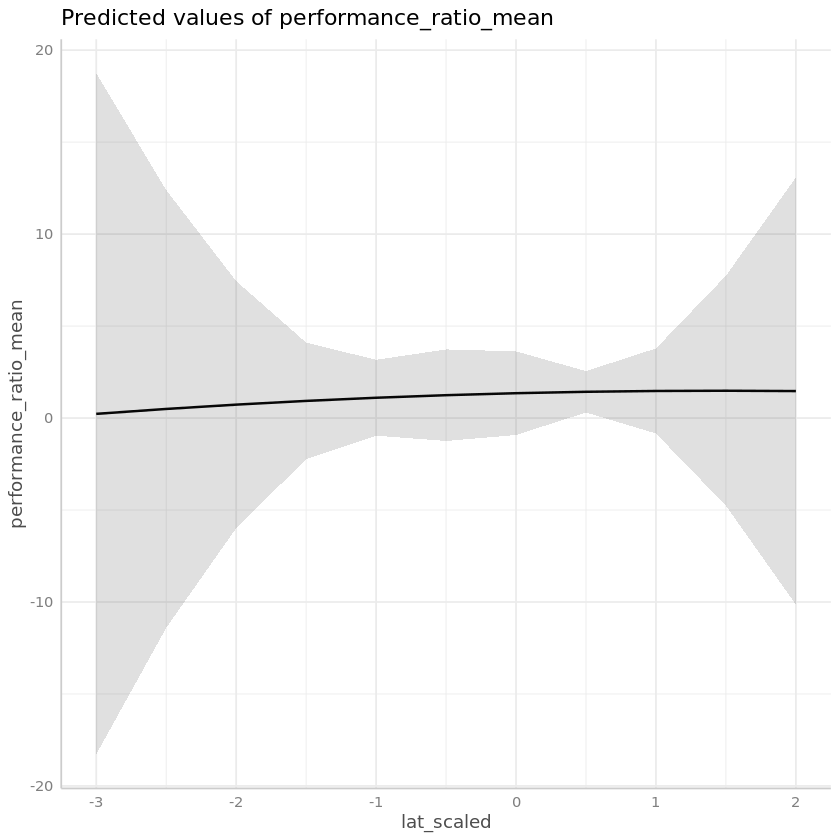

In [417]:
plot(ggeffect(simple_intense_scaled_re, terms='lat_scaled'))

## Absolute Latitude instead of Poly(2)

In [418]:
abslat_re = lmer(performance_ratio_mean ~ (abslat_scaled + sst_scaled  + season)^2 + (1 | isolate), data=mhwPerformance, )

In [345]:
summary(abslat_re)


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ (abslat_scaled + sst_scaled + season)^2 +  
    (1 | isolate)
   Data: mhwPerformance

REML criterion at convergence: 42607.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-18.250  -0.042  -0.004   0.010  65.102 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept)   1.397   1.182  
 Residual             181.321  13.466  
Number of obs: 5299, groups:  isolate, 75

Fixed effects:
                            Estimate Std. Error        df t value Pr(>|t|)  
(Intercept)                   1.0991     0.5433  727.9124   2.023   0.0434 *
abslat_scaled                -0.3428     1.2441 1314.3094  -0.276   0.7830  
sst_scaled                   -0.4032     1.2884 1084.6690  -0.313   0.7544  
seasonspring                  0.6582     0.6035 5265.8475   1.091   0.2754  
seasonsummer                  0.0380     0.5679 5275.5416   0.067   0.94

In [346]:
abslat_re = lmer(performance_ratio_mean ~ (abslat_scaled + sst_scaled  + season)^2 + (1 | isolate), data=intenseMhwPerformance, )

In [347]:
summary(abslat_re)


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ (abslat_scaled + sst_scaled + season)^2 +  
    (1 | isolate)
   Data: intenseMhwPerformance

REML criterion at convergence: 23352.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-13.893  -0.016  -0.002   0.015  49.350 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept)   1.956   1.399  
 Residual             315.263  17.756  
Number of obs: 2721, groups:  isolate, 69

Fixed effects:
                            Estimate Std. Error        df t value Pr(>|t|)
(Intercept)                   0.9814     1.0064  906.2420   0.975    0.330
abslat_scaled                -0.7822     2.2944 1388.6451  -0.341    0.733
sst_scaled                   -0.1679     2.3945 1104.9877  -0.070    0.944
seasonspring                  0.3891     1.1722 2699.8699   0.332    0.740
seasonsummer                  0.0255     1.1038 2701.2936   0.023    0.982


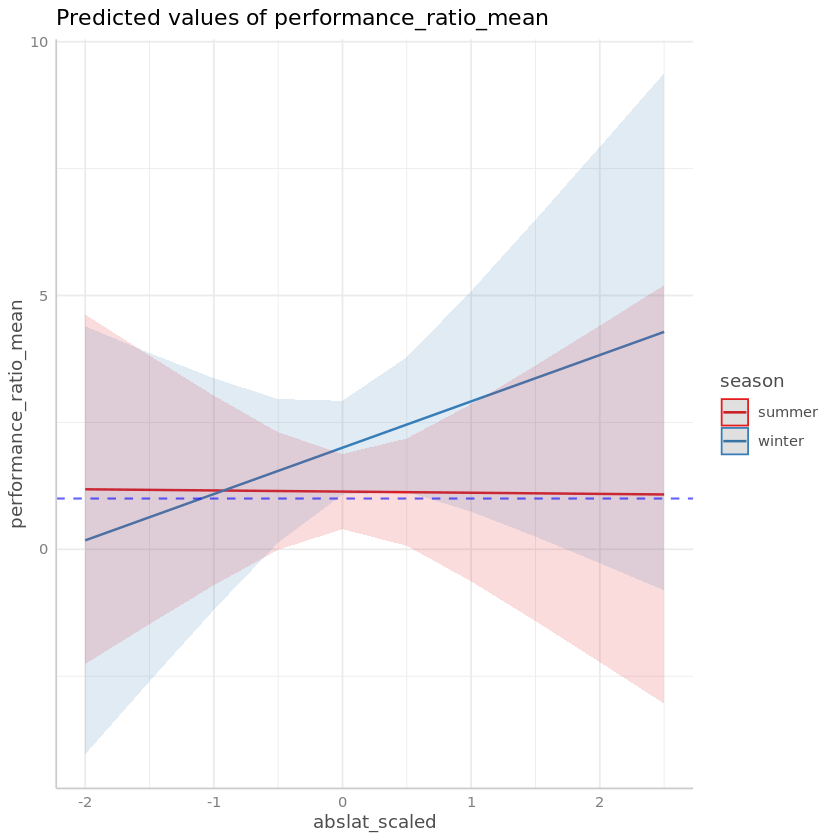

In [419]:
plot(ggeffect(abslat_re, terms=c('abslat_scaled', 'season [summer, winter]'))) + baseline_hline

In [420]:
plot()

ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): argument "x" is missing, with no default


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

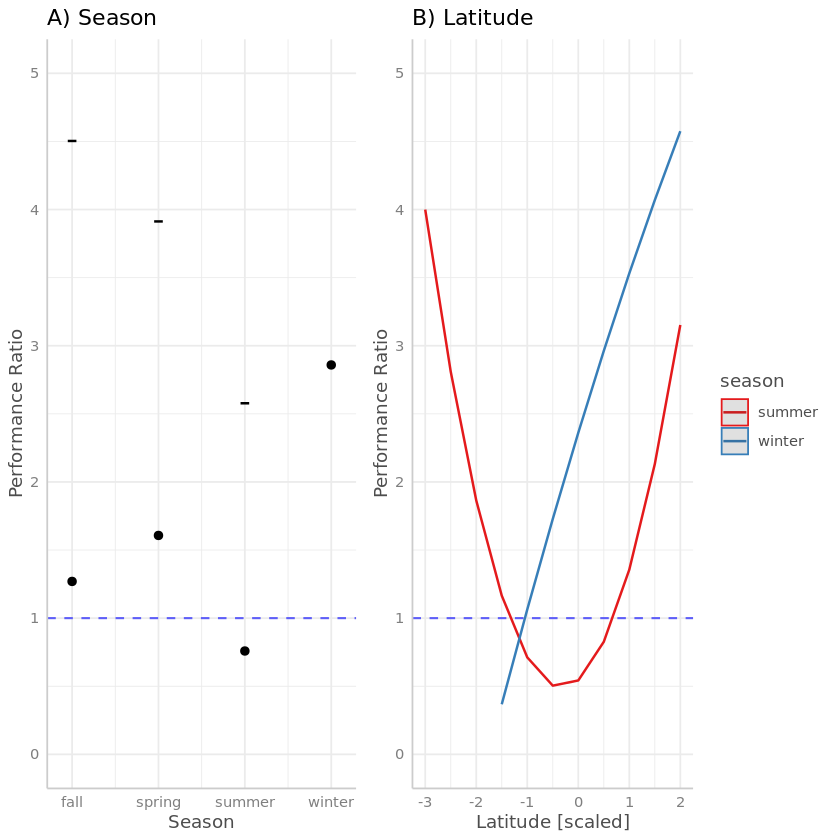

In [421]:
# png("./lat_season.png", width=1440, height=700, res=180)

seas = plot(ggeffect(simple_intense_scaled_re, terms='season')) + 
    baseline_hline + 
    xlab("Season") +
    ylab("Performance Ratio")  +
    ggtitle("A) Season") + 
    ylim(0, 5)



seaslat = plot(ggeffect(simple_intense_scaled_re, terms=c('lat_scaled', 'season [summer, winter]'))) +
    baseline_hline +
    xlab("Latitude [scaled]") +
    ylab("Performance Ratio")  +
    ggtitle("B) Latitude") + 
    ylim(0, 5)

    

grid.arrange(seas, seaslat, nrow=1, widths=c(1,1.3))
# dev.off()
# seaslat

In [351]:
summary(simple_intense_re)


Correlation matrix not shown by default, as p = 18 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ (poly(lat, 2) + current_year_sst_mean +  
    season)^2 + (1 | isolate)
   Data: intenseMhwPerformance

REML criterion at convergence: 23295.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-13.876  -0.018   0.000   0.016  49.303 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept)   2.079   1.442  
 Residual             315.732  17.769  
Number of obs: 2721, groups:  isolate, 69

Fixed effects:
                                      Estimate Std. Error         df t value
(Intercept)                          1.343e+00  5.872e+00  1.180e+03   0.229
poly(lat, 2)1                       -3.253e+01  7.344e+01  8.708e+02  -0.443
poly(lat, 2)2                       -4.537e+01  9.570e+01  1.627e+03  -0.474
current_year_sst_mean               -2.521e-02  3.100e-01  1.093e+03  -0.081
seasonspring                         1.127e+00  6.905e+

In [312]:
tab_model(simple_re, simple_intense_scaled_re, show.stat=TRUE, use.viewer=FALSE, dv.labels=c("Performance Ratio [all events]", "Performance Ratio [intense events]"), file = "simple_intense_re.html")

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


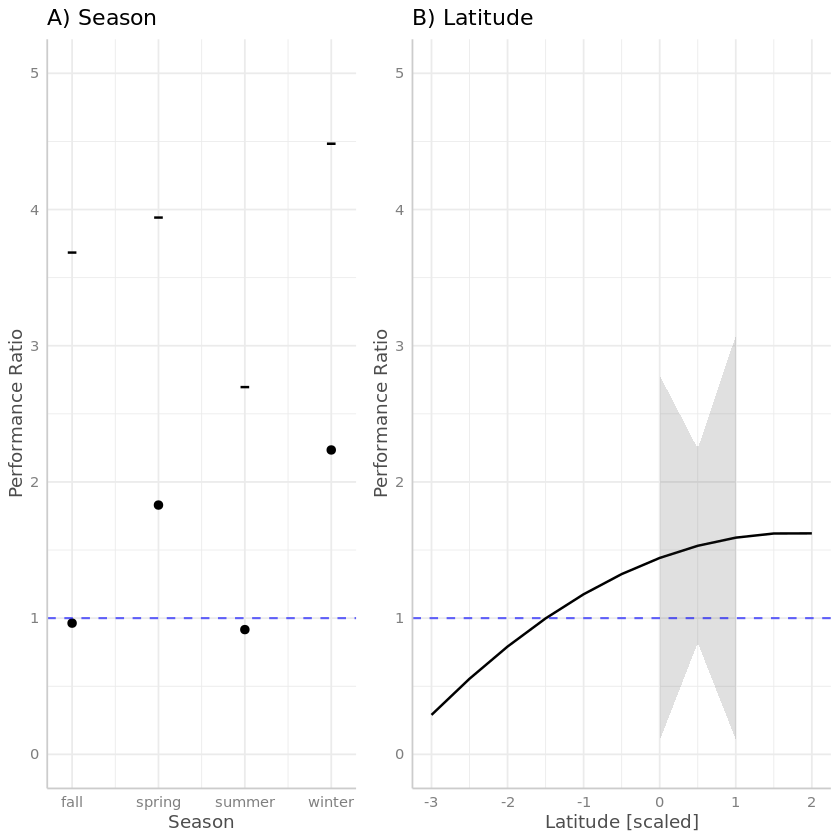

In [352]:
# png("./lat_season_all.png", width=1440, height=700, res=180)

seas = plot(ggeffect(simple_re, terms='season')) + 
    baseline_hline + 
    xlab("Season") +
    ylab("Performance Ratio")  +
    ggtitle("A) Season") + 
    ylim(0, 5)



seaslat = plot(ggeffect(simple_re, terms='lat_scaled')) +
    baseline_hline +
    xlab("Latitude [scaled]") +
    ylab("Performance Ratio")  +
    ggtitle("B) Latitude") + 
    ylim(0, 5)

    

grid.arrange(seas, seaslat, nrow=1, widths=c(1,1.3))
# dev.off()
# seaslat

In [246]:
anova(simple_re, simple_intense_re)

ERROR: Error in anova.merMod(simple_re, simple_intense_re): models were not all fitted to the same size of dataset


In [277]:
png("./compare_coefs.png", width=1440, height=950, res=180)
simple_coefs = plot_model(simple_re, ci.lvl=NA,  show.values = TRUE, value.offset=.4) + ylim(-20, 20) + ggtitle("A) All MHWs")
intense_coefs = plot_model(simple_intense_scaled_re,show.values = TRUE, value.offset=.4, ci.lvl=NA)+ theme(axis.text.y = element_blank()) + ylim(-20, 20) + ggtitle("B) Intense MHWs")
grid.arrange(simple_coefs, intense_coefs, nrow=1, widths=c(2., 1) )
dev.off()

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


png 
  2